# Import 

In [1]:
import pandas as pd
import numpy as np
import glob
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
from plotly import graph_objects as go

import sys
sys.path.append('/home/s312657018/TBrain/code')
import importlib
import dataset
importlib.reload(dataset)
from dataset import process_serial

In [3]:
avg = pd.read_csv('/home/s312657018/TBrain/data-preprocess/All_min_Training_Data.csv')

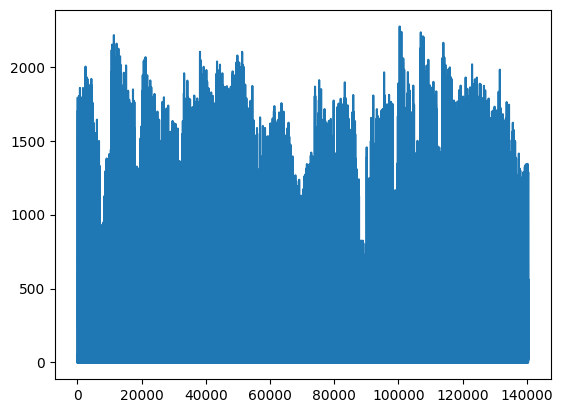

In [5]:
plt.plot(avg['Power(mW)'])
# avgdata_dict['avgdata_01'][:48]

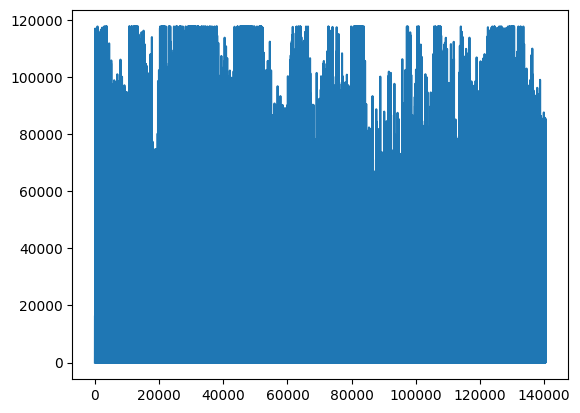

In [6]:
plt.plot(avg['Sunlight(Lux)'])

---------------

# Test Data

##### Test data 終止提供觀測時間，從氣象局網站抓取花蓮站的其他特徵資料

### Pressure(hpa),	Temperature(°C),	Humidity(%),	WindSpeed(m/s)

In [5]:
import xml.etree.ElementTree as ET
from datetime import datetime
import pandas as pd

# 讀取 XML 文件
tree = ET.parse('/home/s312657018/TBrain/data-preprocess/C-B0024-002.xml') 
root = tree.getroot()

# 初始化空列表來存儲每個時間點的數據
data = []

# 定義命名空間（如果存在命名空間）
ns = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}

# 設定日期範圍和時間範圍
start_date = datetime.strptime("2024-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2024-12-31", "%Y-%m-%d")
start_time = datetime.strptime("09:00:00", "%H:%M:%S").time()

# 安全轉換函數
def safe_float(value, default=0.0):
    """安全轉換為 float，如果無法轉換則使用預設值"""
    try:
        return float(value)
    except (ValueError, TypeError):
        return default

for location in root.findall('.//cwa:location', ns):
    station_id = location.find('.//cwa:StationID', ns).text
    station_name = location.find('.//cwa:StationName', ns).text
    # station_name = station_name_node if station_name_node is not None else None

    # 確保站點名稱是 '花蓮'
    if station_name != '花蓮':
        continue
        
    # 遍歷所有的 stationObsTime 節點，提取數據
    for station in root.findall('.//cwa:stationObsTime', ns):
        # 提取日期和時間
        data_time = station.find('cwa:DataTime', ns).text
        date_str, time_str = data_time.split('T')  # 拆分出日期和時間部分
        date_obj = datetime.strptime(date_str, "%Y-%m-%d")  # 將日期轉換為 datetime 對象
        time_obj = datetime.strptime(time_str.split("+")[0], "%H:%M:%S").time()  # 時間部分轉換為 time 對象

        # 只處理在指定日期和時間範圍內的數據
        if start_date <= date_obj <= end_date and start_time <= time_obj:
            # 提取 weatherElements 中的幾個所需元素
            weather_elements = station.find('cwa:weatherElements', ns)
            
            # 只提取所需的幾個元素
            air_pressure = safe_float(weather_elements.find('cwa:AirPressure', ns).text if weather_elements.find('cwa:AirPressure', ns) is not None else None)
            air_temperature = safe_float(weather_elements.find('cwa:AirTemperature', ns).text if weather_elements.find('cwa:AirTemperature', ns) is not None else None)
            relative_humidity = safe_float(weather_elements.find('cwa:RelativeHumidity', ns).text if weather_elements.find('cwa:RelativeHumidity', ns) is not None else None)
            wind_speed = safe_float(weather_elements.find('cwa:WindSpeed', ns).text if weather_elements.find('cwa:WindSpeed', ns) is not None else None)

            # 添加到數據列表
            data.append({
                "StationID": station_id,
                "StationName": station_name,
                "Date": date_str,
                "Datetime": data_time,
                'Pressure(hpa)': air_pressure,
                'Temperature(°C)': air_temperature,
                'Humidity(%)': relative_humidity,
                'WindSpeed(m/s)': wind_speed
            })

# 將數據轉換為 DataFrame
df = pd.DataFrame(data)

# 填補空值
df = df.fillna(method='ffill')  # 使用前向填充填補缺失值
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.tz_localize(None)

# 確保數據行數符合需求
# df = df.iloc[:4943, :] if len(df) > 4943 else df
# df = df.sort_index()  # 确保按索引排序
# df = df.drop_duplicates(subset=['Datetime'], keep='first')
# df=df.sort_values(by='Datetime')

# # 打印數據檢查
# print(df.shape)
# # print(df.head())
# # print(df.info())

# df.to_csv('/home/s312657018/TBrain/data-preprocess/weather_data.csv', index=False)
# print("Processed weather data saved.")
# df

df_median = df.groupby('Datetime').agg({
    'StationID': 'first',  # StationID 保留第一笔记录（因为相同时间的 StationID 是一致的）
    'StationName': 'first',  # StationName 保留第一笔记录
    'Pressure(hpa)': 'median',  # 计算中位数
    'Temperature(°C)': 'median',  # 计算中位数
    'Humidity(%)': 'median',  # 计算中位数
    'WindSpeed(m/s)': 'median'  # 计算中位数
}).reset_index()  # 重置索引

# 打印數據檢查
print(df_median.shape)
print(df_median.head())
print(df.describe())
# 保存至 CSV 文件
# df_median.to_csv('/home/s312657018/TBrain/data-preprocess/weather_data.csv', index=False)
# print("Processed weather data with median saved.")

/tmp/ipykernel_1900480/2019724061.py:72: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # 使用前向填充填補缺失值


(4665, 7)
             Datetime StationID StationName  Pressure(hpa)  Temperature(°C)  \
0 2024-01-01 09:00:00    466990          花蓮         1018.5             17.4   
1 2024-01-01 10:00:00    466990          花蓮         1018.7             17.9   
2 2024-01-01 11:00:00    466990          花蓮         1018.2             18.4   
3 2024-01-01 12:00:00    466990          花蓮         1017.2             18.8   
4 2024-01-01 13:00:00    466990          花蓮         1016.4             19.1   

   Humidity(%)  WindSpeed(m/s)  
0         67.0             4.0  
1         66.0             4.2  
2         65.0             4.4  
3         64.0             4.3  
4         64.0             4.6  
                            Datetime  Pressure(hpa)  Temperature(°C)  \
count                         125955  125955.000000    125955.000000   
mean   2024-06-04 16:00:00.000000512     974.545092        23.714305   
min              2024-01-01 09:00:00       0.000000       -10.000000   
25%              2024-03-18 2

In [15]:
# from scipy.spatial.distance import cdist

# # 加载气象局数据
# weather_data = pd.read_csv('/home/s312657018/TBrain/data-preprocess/weather_data.csv')  # 气象局数据
# weather_data['Datetime'] = pd.to_datetime(weather_data['Datetime']).dt.tz_localize(None)
# # print(weather_data.head())

# # 加载比赛数据
# competition_data = pd.read_csv('/home/s312657018/TBrain/data-preprocess/AvgDATA.csv')  # 比赛数据
# competition_data['Datetime'] = pd.to_datetime(competition_data['Datetime'])
# # print(competition_data.head())

# features = ['Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'WindSpeed(m/s)']

# # 提取气象局数据的特征
# weather_features = weather_data[[f for f in features]].values

# # 提取比赛数据的特征
# competition_features = competition_data[[f for f in features]].values

# # 计算欧几里得距离
# distances = cdist(competition_features, weather_features, metric='euclidean')

# # 找到最接近的记录的索引
# closest_indices = distances.argmin(axis=1)

# # 根据索引提取最相似的记录
# closest_records = weather_data.iloc[closest_indices]

In [ ]:
# df_second = df.groupby('Datetime').nth(1).reset_index()
# df_second.to_csv('/home/s312657018/TBrain/data-preprocess/weather_data.csv', index=False)
# print("Processed weather data saved.")

Processed weather data saved.


### 開始差分資料成10分鐘一筆

In [4]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

weather_data = pd.read_csv('/home/s312657018/TBrain/data-preprocess/weather_data.csv')  # 气象局数据
weather_data['Datetime'] = pd.to_datetime(weather_data['Datetime'])
# print(weather_data.head())

# 加载比赛数据
competition_data = pd.read_csv('/home/s312657018/TBrain/data-preprocess/AvgDATA.csv')  # 比赛数据
competition_data['Datetime'] = pd.to_datetime(competition_data['Datetime'])
# print(competition_data.head())

# 创建 10 分钟的时间序列
start_time = competition_data['Datetime'].min()
end_time = competition_data['Datetime'].max()
time_range = pd.date_range(start=start_time, end=end_time, freq='10T')  # 10 分钟间隔

# 插值气象局数据到 10 分钟
interpolated_weather = weather_data.set_index('Datetime').reindex(time_range).interpolate(method='time').reset_index()
interpolated_weather.rename(columns={'index': 'Datetime'}, inplace=True)
# interpolated_weather = interpolated_weather.drop('StationName', axis=1)
# interpolated_weather = interpolated_weather.drop('Date', axis=1)
interpolated_weather

/tmp/ipykernel_1900480/810029968.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start=start_time, end=end_time, freq='10T')  # 10 分钟间隔


Datetime  Unnamed: 0  StationID  Pressure(hpa)  \
0     2024-01-01 09:00:00           0   466990.0    1018.500000   
1     2024-01-01 09:10:00           1   466990.0    1018.533333   
2     2024-01-01 09:20:00           2   466990.0    1018.566667   
3     2024-01-01 09:30:00           3   466990.0    1018.600000   
4     2024-01-01 09:40:00           4   466990.0    1018.633333   
...                   ...         ...        ...            ...   
35023 2024-08-31 14:10:00       35023   466990.0    1004.100000   
35024 2024-08-31 14:20:00       35024   466990.0    1004.100000   
35025 2024-08-31 14:30:00       35025   466990.0    1004.100000   
35026 2024-08-31 14:40:00       35026   466990.0    1004.100000   
35027 2024-08-31 14:50:00       35027   466990.0    1004.100000   

       Temperature(°C)  Humidity(%)  WindSpeed(m/s)  Sunlight(Lux)  
0            17.400000    67.000000        4.000000     5093.02280  
1            17.483333    66.833333        4.033333     4764.88670  
2            17.566667    66.666667        4.066667     4314.00080  
3            17.650000    66.500000        4.100000     3907.11725  
4            17.733333    66.333333        4.133333     3779.64775  
...                ...          ...             ...            ...  
35023        31.500000    72.000000        2.500000    13713.74385  
35024        31.500000    72.000000        2.500000    13713.74385  
35025        31.500000    72.000000        2.500000    13713.74385  
35026        31.500000    72.000000        2.500000    13713.74385  
35027        31.500000    72.000000        2.500000    13713.74385  

[35028 rows x 8 columns]

R² score: 0.7307
Mean Squared Error: 266604190.1259


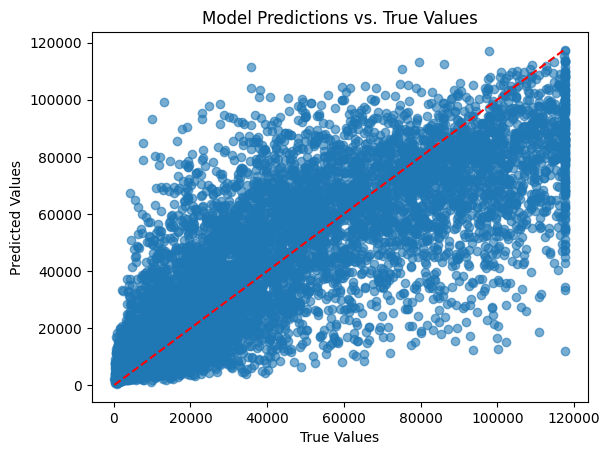

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 加载比赛数据
competition_data_path = '/home/s312657018/TBrain/data-preprocess/AvgDATA.csv'
competition_data = pd.read_csv(competition_data_path)

# 确保数据无缺失
features = ['Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)']
target = 'Sunlight(Lux)'
data = competition_data[features + [target]].dropna()

# 分离训练和测试数据
X = data[features]
y = data[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# 验证模型
y_pred = rf_model.predict(X_valid)

# 打印模型性能
print(f"R² score: {r2_score(y_valid, y_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_valid, y_pred):.4f}")

plt.scatter(y_valid, y_pred, alpha=0.6)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Model Predictions vs. True Values")
plt.show()


In [41]:
# 加载测试集
# test_data_path = '/home/s312657018/TBrain/data-preprocess/weather_data.csv'
# test_data = pd.read_csv(test_data_path)

# 确保测试数据包含用于预测的特征
test_features = ['Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)']

# 假设测试数据没有 Sunlight(Lux)，我们用训练好的随机森林模型进行预测
# 首先要确保测试数据的特征齐全并无缺失值
if not all([col in interpolated_weather.columns for col in test_features]):
    print(f"Test data is missing some required features: {test_features}")
else:
    # 只提取需要的特征列，并确保没有缺失值
    test_X = interpolated_weather[test_features].fillna(0)  # 如果有缺失值，用 0 填充或者用插值方法

    # 使用训练好的模型进行预测
    interpolated_weather['Sunlight(Lux)'] = rf_model.predict(test_X)

    # 保存预测结果到 CSV 文件
    interpolated_weather.to_csv('test_data_with_predictions.csv', index=False)
    print("Test data with predictions saved to 'test_data_with_predictions.csv'.")

# 检查部分预测结果
# interpolated_weather = interpolated_weather.drop('Unnamed: 0', axis=1)
interpolated_weather.to_csv('/home/s312657018/TBrain/data-preprocess/weather_data.csv')
interpolated_weather

Test data with predictions saved to 'test_data_with_predictions.csv'.


Datetime  StationID  Pressure(hpa)  Temperature(°C)  \
0     2024-01-01 09:00:00   466990.0    1018.500000        17.400000   
1     2024-01-01 09:10:00   466990.0    1018.533333        17.483333   
2     2024-01-01 09:20:00   466990.0    1018.566667        17.566667   
3     2024-01-01 09:30:00   466990.0    1018.600000        17.650000   
4     2024-01-01 09:40:00   466990.0    1018.633333        17.733333   
...                   ...        ...            ...              ...   
35023 2024-08-31 14:10:00   466990.0    1004.100000        31.500000   
35024 2024-08-31 14:20:00   466990.0    1004.100000        31.500000   
35025 2024-08-31 14:30:00   466990.0    1004.100000        31.500000   
35026 2024-08-31 14:40:00   466990.0    1004.100000        31.500000   
35027 2024-08-31 14:50:00   466990.0    1004.100000        31.500000   

       Humidity(%)  WindSpeed(m/s)  Sunlight(Lux)  
0        67.000000        4.000000     5093.02280  
1        66.833333        4.033333     4764.88670  
2        66.666667        4.066667     4314.00080  
3        66.500000        4.100000     3907.11725  
4        66.333333        4.133333     3779.64775  
...            ...             ...            ...  
35023    72.000000        2.500000    13713.74385  
35024    72.000000        2.500000    13713.74385  
35025    72.000000        2.500000    13713.74385  
35026    72.000000        2.500000    13713.74385  
35027    72.000000        2.500000    13713.74385  

[35028 rows x 7 columns]

## 對每個側站做轉換

In [43]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# 特征列表
features = ['Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'WindSpeed(m/s)', 'Sunlight(Lux)']
results = []

# 按测站分组
stations = merged_data['Station_ID'].unique()

for station_id in stations:
    # 筛选每个测站的数据
    station_data = merged_data[merged_data['Station_ID'] == station_id]
    
    for feature in features:
        target = feature  # 比赛方变量
        predictor = feature  # 气象局变量

        # 确保数据无缺失值
        data = station_data[[predictor + '_x', target + '_y']].dropna()
        if data.empty:
            print(f"No data for Station {station_id} and feature {feature}. Skipping.")
            continue

        X = data[[predictor + '_x']].values  # 气象局数据
        y = data[target + '_y'].values  # 比赛方数据

        # 拟合线性模型
        model = LinearRegression()
        model.fit(X, y)

        # 提取拟合参数
        a = model.coef_[0]  # 比例系数
        b = model.intercept_  # 偏移量
        results.append({
            'Station_ID': station_id,
            'Feature': feature,
            'Coefficient': a,
            'Intercept': b
        })
        print(f"Station {station_id} | {feature}: Y = {a:.4f} * X + {b:.4f}")

# 转换结果存储到 DataFrame
transformation_params = pd.DataFrame(results)
transformation_params = transformation_params.sort_values(by = 'Station_ID')

# 保存转换参数到 CSV
transformation_params.to_csv('/home/s312657018/TBrain/data-preprocess/transformation_params.csv', index=False)
print("Transformation parameters saved.")


Station 1 | Pressure(hpa): Y = 0.0497 * X + 960.1951
Station 1 | Temperature(°C): Y = 0.4835 * X + 8.2614
Station 1 | Humidity(%): Y = 0.1578 * X + 65.6840
Station 1 | WindSpeed(m/s): Y = 0.1013 * X + 2.7309
Station 1 | Sunlight(Lux): Y = 0.0459 * X + 6837.7087
Station 17 | Pressure(hpa): Y = 0.8655 * X + 132.5589
Station 17 | Temperature(°C): Y = 0.3909 * X + 10.9458
Station 17 | Humidity(%): Y = 0.2326 * X + 59.3806
Station 17 | WindSpeed(m/s): Y = 0.0000 * X + 2.8102
Station 17 | Sunlight(Lux): Y = 0.0496 * X + 6741.2716
Station 8 | Pressure(hpa): Y = 0.8821 * X + 119.8063
Station 8 | Temperature(°C): Y = 0.6105 * X + 6.5542
Station 8 | Humidity(%): Y = 0.2581 * X + 58.7054
Station 8 | WindSpeed(m/s): Y = -0.3129 * X + 2.6809
Station 8 | Sunlight(Lux): Y = 0.0378 * X + 7645.4806
Station 2 | Pressure(hpa): Y = 0.9108 * X + 92.2052
Station 2 | Temperature(°C): Y = 0.5288 * X + 6.9269
Station 2 | Humidity(%): Y = 0.1754 * X + 64.8135
Station 2 | WindSpeed(m/s): Y = 0.1255 * X + 2.6464


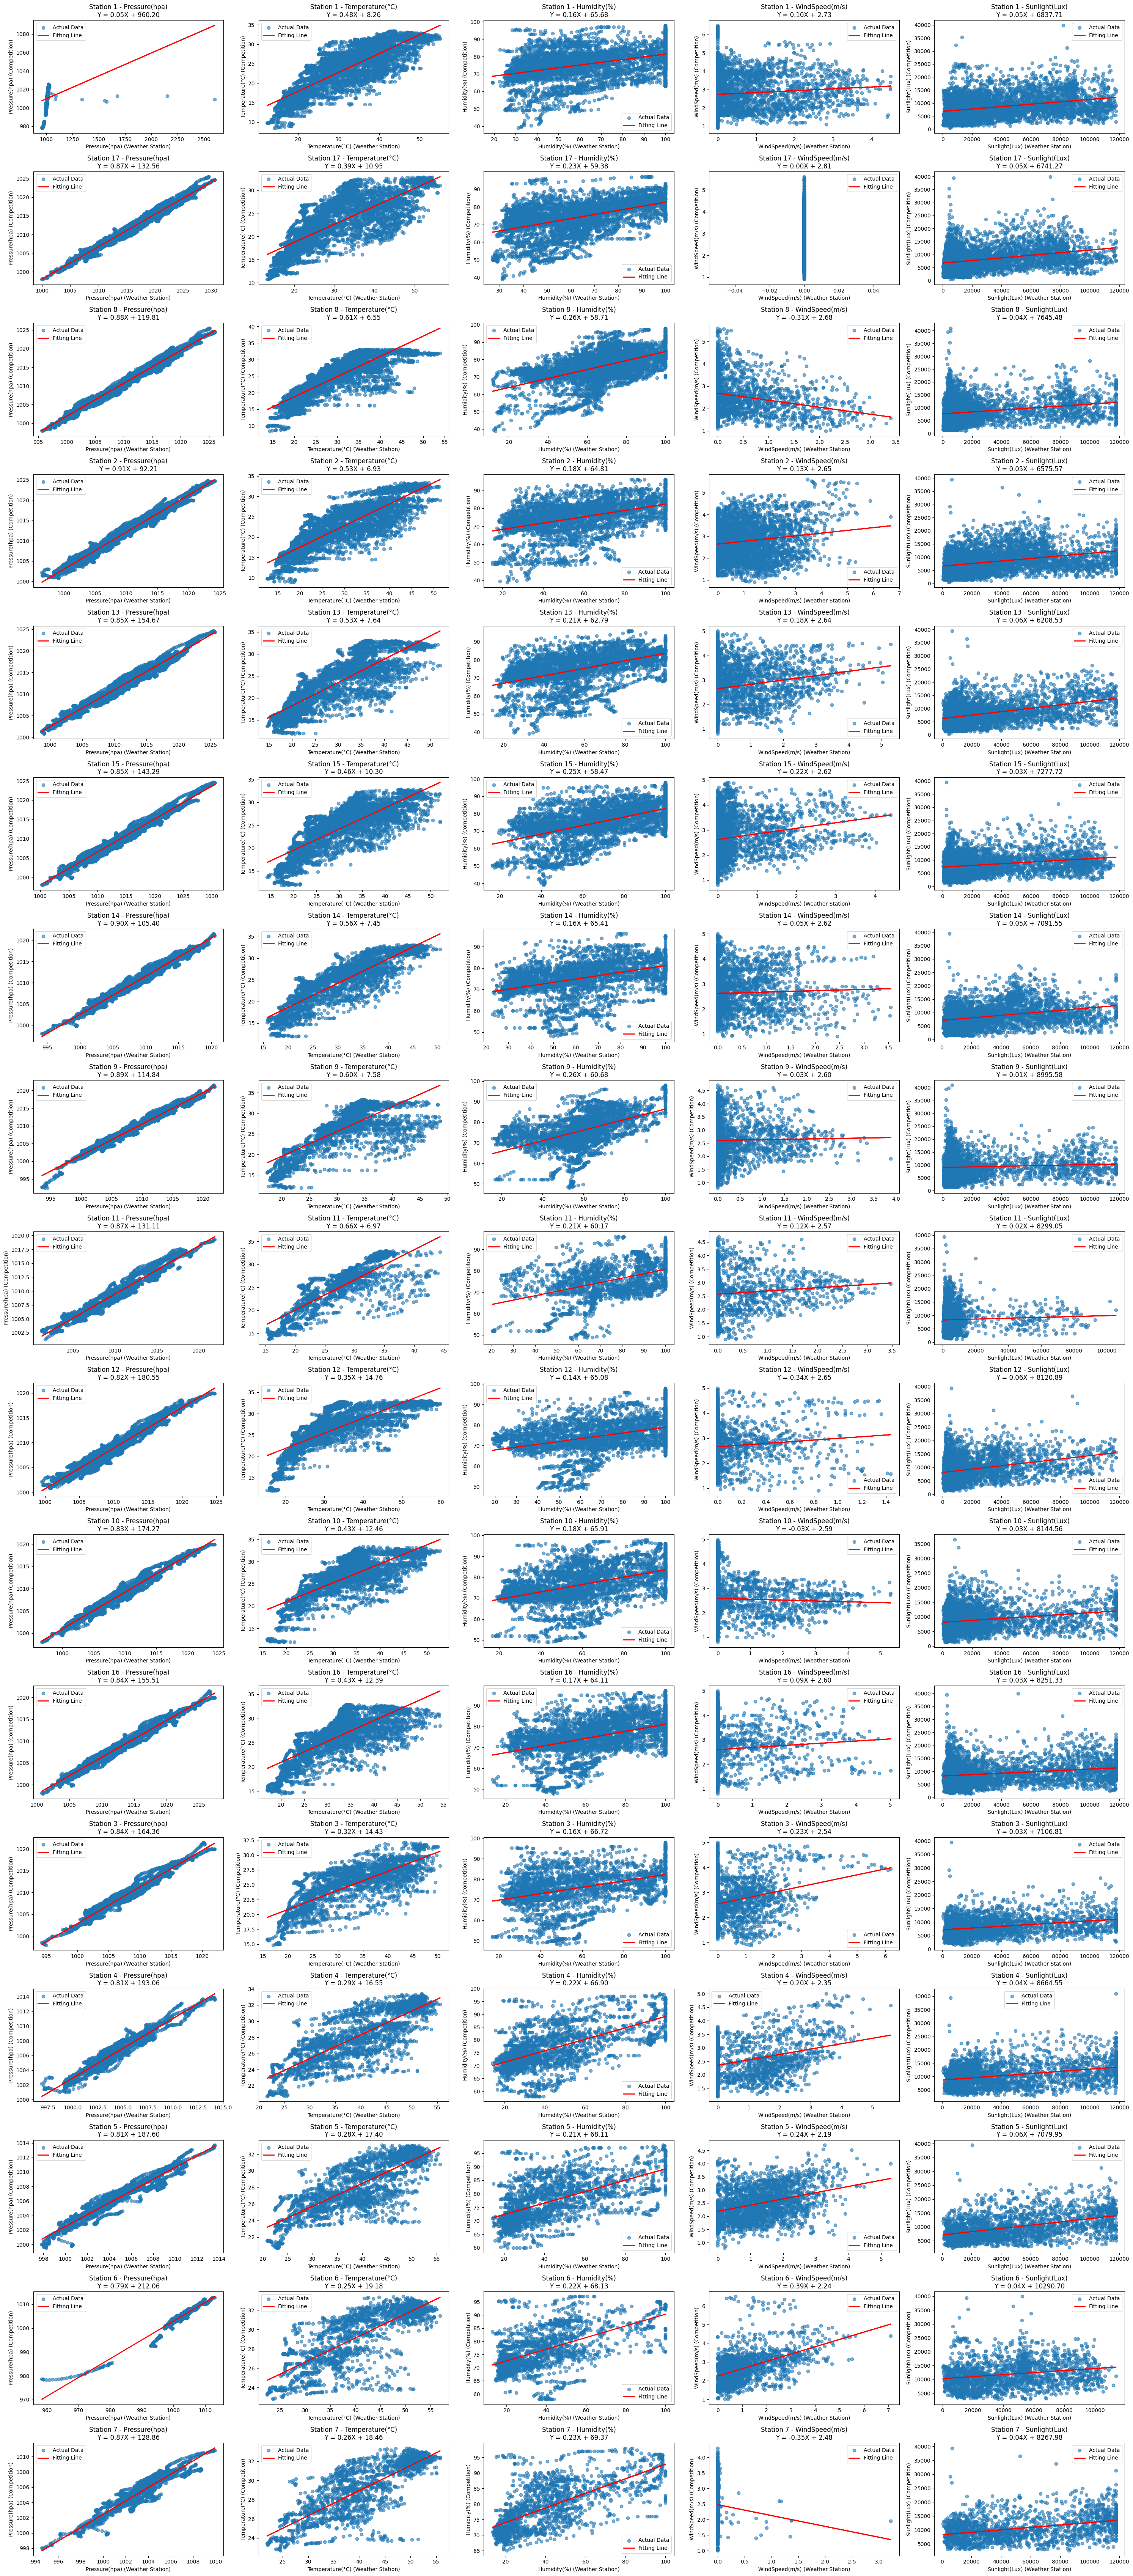

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# 创建子图，动态适配测站数量和特征数量
num_stations = len(stations)
num_features = len(features)
fig, axes = plt.subplots(num_stations, num_features, figsize=(6 * num_features, 4 * num_stations), sharey=False)

for station_idx, station_id in enumerate(stations):
    # 筛选每个测站的数据
    station_data = merged_data[merged_data['Station_ID'] == station_id]

    for feature_idx, feature in enumerate(features):
        target = feature  # 比赛方变量
        predictor = feature  # 气象局变量

        # 确保数据无缺失值
        data = station_data[[predictor + '_x', target + '_y']].dropna()
        if data.empty:
            print(f"No data for Station {station_id} and feature {feature}. Skipping.")
            continue

        X = data[[predictor + '_x']].values  # 气象局数据
        y = data[target + '_y'].values  # 比赛方数据

        # 拟合线性模型
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)

        # 获取拟合参数
        a = model.coef_[0]
        b = model.intercept_

        # 绘制散点图和拟合线
        ax = axes[station_idx, feature_idx] if num_stations > 1 else axes[feature_idx]
        ax.scatter(X, y, alpha=0.6, label='Actual Data')
        ax.plot(X, y_pred, color='red', linewidth=2, label='Fitting Line')
        ax.set_title(f"Station {station_id} - {feature}\nY = {a:.2f}X + {b:.2f}")
        ax.set_xlabel(f"{feature} (Competition)")
        ax.set_ylabel(f"{feature} (Weather Station)")
        ax.legend()

# 调整布局
plt.tight_layout()
plt.show()


In [1]:
import xml.etree.ElementTree as ET
import pandas as pd

# 讀取 XML 檔案
file_path = '/home/s312657018/TBrain/data-preprocess/C-B0024-002.xml'  # 替換成您的檔案路徑
tree = ET.parse(file_path)
root = tree.getroot()

# 定義命名空間
ns = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}

# 初始化空列表存儲數據
data = []

# 解析資料
for location in root.findall('.//cwa:location', ns):
    station_id = location.find('.//cwa:StationID', ns).text
    station_name = location.find('.//cwa:StationName', ns).text

    for obs_time in location.findall('.//cwa:stationObsTime', ns):
        data_time = obs_time.find('cwa:DataTime', ns).text
        weather_elements = obs_time.find('cwa:weatherElements', ns)

        # 讀取 weatherElements 中的所有變數
        record = {
            'StationID': station_id,
            'StationName': station_name,
            'DataTime': data_time
        }

        if weather_elements is not None:
            for element in weather_elements:
                tag = element.tag.split('}')[-1]  # 去掉命名空間前綴
                record[tag] = element.text

        # 添加記錄到數據列表
        data.append(record)

# 將數據轉換為 DataFrame
df = pd.DataFrame(data)

# 保存為 CSV
output_path = 'complete_weather_data.csv'
df.to_csv(output_path, index=False, encoding='utf-8')
print(f"完整資料已儲存至 '{output_path}'")


完整資料已儲存至 'complete_weather_data.csv'
